## **Conformal Prediction using Energy Hospital Load**

One example of the NP data is the electricity consumption of a hospital in SF. It has hourly reservation for the entire year of 2015.

### Library Setup
Requires Python 3.9+

In [1]:
!python --version

Python 3.9.12


Install from scratch

In [2]:
# !git clone https://github.com/ourownstory/neural_prophet.git
# !cd neural_prophet
# !pip install -e ".[dev]"

### Extract Data and Split Data into Train, Val, Cal, and Test


**Extract Data From GitHub**

In [3]:
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

In [4]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
file = 'energy/SF_hospital_load.csv'

In [5]:
data_df = pd.read_csv(data_location + file)

In [6]:
data_df.head(5)

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338
3,2015-01-01 04:00:00,778.737196
4,2015-01-01 05:00:00,787.835835


In [7]:
data_df.tail(5)

,ds,y
8755,2015-12-31 20:00:00,845.563081
8756,2015-12-31 21:00:00,827.530521
8757,2015-12-31 22:00:00,829.256300
8758,2015-12-31 23:00:00,813.937205
8759,2016-01-01 00:00:00,815.588584


**Split data into train, val, cal, and test in that order**

Do we need to instantiate a NP model `m` in order to split the df into train and test? If so, does the NP params make any diff to the outcome of this split? I'm presuming no atm.

In [8]:
m = NeuralProphet()

In [9]:
train_df, test_df = m.split_df(data_df, freq='H', valid_p = 1.0/16)
train_df, cal_df = m.split_df(train_df, freq='H', valid_p = 1.0/11)
train_df, val_df = m.split_df(train_df, freq='H', valid_p = 1.0/10)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_

In [10]:
train_df.shape, val_df.shape, cal_df.shape, test_df.shape

((6721, 2), (746, 2), (746, 2), (547, 2))

In [11]:
print(f"Train set time range:        {train_df['ds'].min()} - {train_df['ds'].max()}")
print(f"Validation set time range:   {val_df['ds'].min()} - {val_df['ds'].max()}")
print(f"Calibration set time range:  {cal_df['ds'].min()} - {cal_df['ds'].max()}")
print(f"Test set time range:         {test_df['ds'].min()} - {test_df['ds'].max()}")

Train set time range:        2015-01-01 01:00:00 - 2015-10-08 01:00:00
Validation set time range:   2015-10-08 02:00:00 - 2015-11-08 03:00:00
Calibration set time range:  2015-11-08 04:00:00 - 2015-12-09 05:00:00
Test set time range:         2015-12-09 06:00:00 - 2016-01-01 00:00:00


**Plot train_df**

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [13]:
x_size = 16
y_size = 6
figsize = (x_size, y_size)

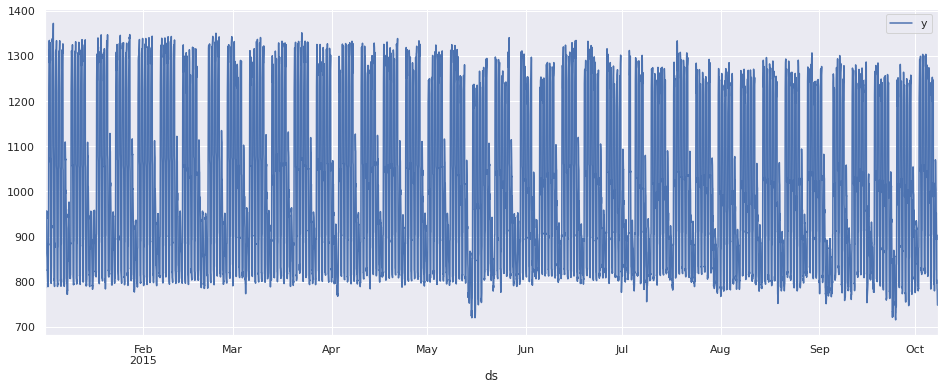

In [14]:
train_df.set_index('ds').plot(figsize=figsize);

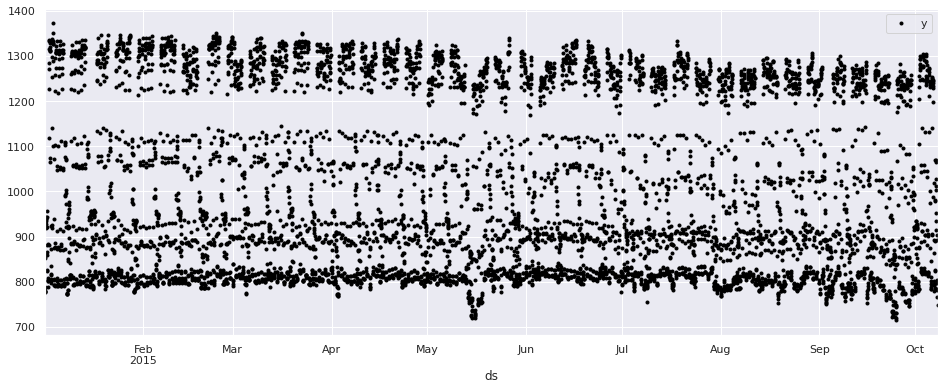

In [15]:
train_df.set_index('ds').plot(marker='.', linestyle='none', colormap='gray', figsize=figsize);

### Train the NP Models (with 5th/95th Quantiles)
- `m1`: NP with default features
- `m2`: NP with parametric time-based features (like in Facebook Prophet)
- `m3`: NP with 1-layer AR
- `m4`: NP with 4-layer deep AR

In [16]:
quantile_lo, quantile_hi = 0.05, 0.95
quantiles = [quantile_lo, quantile_hi]
n_lags = 3*24

In [17]:
m1 = NeuralProphet(
    quantiles=quantiles,
)
m2 = NeuralProphet(
    weekly_seasonality=6,
    daily_seasonality=10,
    trend_reg=1,
    learning_rate=0.01,
    quantiles=quantiles,
)
m3 = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    ar_reg=1,
    learning_rate=0.01,
    quantiles=quantiles,
)
m4 = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.003,
    quantiles=quantiles,
)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.


Train the 4 models. You can either concatonate the train and val set into one full training set or use the val set separately for hyperparameter tuning. I recommend trying both ways to see how to performance evaluation metrics change.

In [ ]:
%%time
random_seed = 0

# Conconate train_df and val_df as full training set
set_random_seed(random_seed)
metrics1 = m1.fit(pd.concat([train_df, val_df]), freq='H')
set_random_seed(random_seed)
metrics2 = m2.fit(pd.concat([train_df, val_df]), freq='H')
set_random_seed(random_seed)
metrics3 = m3.fit(pd.concat([train_df, val_df]), freq='H')
set_random_seed(random_seed)
metrics4 = m4.fit(pd.concat([train_df, val_df]), freq='H')

# Use val_df for validation
# set_random_seed(random_seed)
# metrics1 = m1.fit(train_df, freq='H', validation_df=val_df)
# set_random_seed(random_seed)
# metrics2 = m2.fit(train_df, freq='H', validation_df=val_df)
# set_random_seed(random_seed)
# metrics3 = m3.fit(train_df, freq='H', validation_df=val_df)
# set_random_seed(random_seed)
# metrics4 = m4.fit(train_df, freq='H', validation_df=val_df)
# metrics4 = m4.fit(train_df, freq='H', validation_df=val_df, progress='plot')

In [19]:
metrics1.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
110,0.009335,64.752761,80.731819,0.008858,0.0


In [20]:
metrics2.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
110,0.00572,44.985247,62.022904,0.013512,0.007895


In [21]:
metrics3.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
110,0.001844,23.764175,35.099999,0.003229,0.001175


In [22]:
metrics4.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
110,0.000153,7.067386,10.083366,0.000155,0.0


**Get forecasts of out-of-sample (OOS) test_df**

In [23]:
forecast1 = m1.predict(test_df)[n_lags:]
forecast2 = m2.predict(test_df)[n_lags:]
forecast3 = m3.predict(test_df)[n_lags:]
forecast4 = m4.predict(test_df)[n_lags:]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [24]:
forecast1.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily
72,2015-12-12 06:00:00,879.551547,237.674772,1117.226318,1007.979248,1185.521484,1063.817139,61.650097,-8.240889
73,2015-12-12 07:00:00,1102.066076,122.222742,1224.288818,1101.569092,1292.337891,1063.856567,60.726612,99.705711
74,2015-12-12 08:00:00,1214.971839,74.834191,1289.806030,1176.931763,1345.252930,1063.895996,59.697750,166.212280
75,2015-12-12 09:00:00,1257.597327,49.499353,1307.096680,1210.787354,1357.378784,1063.935303,58.594906,184.566467
76,2015-12-12 10:00:00,1293.807143,11.261094,1305.068237,1216.065063,1354.136230,1063.974731,57.448212,183.645309


In [25]:
forecast2.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily
72,2015-12-12 06:00:00,879.551547,256.784024,1136.335571,1094.703979,1194.212891,1071.216919,70.309578,-5.190846
73,2015-12-12 07:00:00,1102.066076,164.000819,1266.066895,1241.757568,1309.531982,1071.261597,77.058235,117.747009
74,2015-12-12 08:00:00,1214.971839,86.034997,1301.006836,1298.626953,1340.679932,1071.306396,82.131912,147.568466
75,2015-12-12 09:00:00,1257.597327,86.418542,1344.015869,1323.738281,1372.608643,1071.351196,85.320251,187.344330
76,2015-12-12 10:00:00,1293.807143,52.757066,1346.564209,1329.041138,1371.403564,1071.395996,86.519897,188.648331


In [26]:
forecast3.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend
72,2015-12-12 06:00:00,879.551547,-4.145907,875.40564,834.49884,918.954468,128.263489,747.142151
73,2015-12-12 07:00:00,1102.066076,-29.101721,1072.964355,1032.056885,1116.513428,325.822174,747.142151
74,2015-12-12 08:00:00,1214.971839,-39.533118,1175.438721,1134.531006,1218.987793,428.296631,747.142151
75,2015-12-12 09:00:00,1257.597327,20.0953,1277.692627,1236.784302,1321.241333,530.550537,747.142151
76,2015-12-12 10:00:00,1293.807143,17.867173,1311.674316,1270.765747,1355.221924,564.532104,747.142151


In [27]:
forecast4.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend
72,2015-12-12 06:00:00,879.551547,4.392789,883.944336,876.346191,888.811707,-63.687786,947.632141
73,2015-12-12 07:00:00,1102.066076,9.114222,1111.180298,1092.691528,1122.76001,163.548203,947.632141
74,2015-12-12 08:00:00,1214.971839,13.324914,1228.296753,1217.268921,1241.771606,280.664581,947.632141
75,2015-12-12 09:00:00,1257.597327,8.221765,1265.819092,1254.519043,1274.89917,318.187012,947.632141
76,2015-12-12 10:00:00,1293.807143,3.247667,1297.05481,1285.453125,1308.62915,349.422699,947.632141


**Plot QR forecasts with OOS test_df**

In [28]:
cutoff = 7*24 # 0
x_size = 10
y_size = 5
figsize = (x_size, y_size)
plotting_backend = 'default'

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


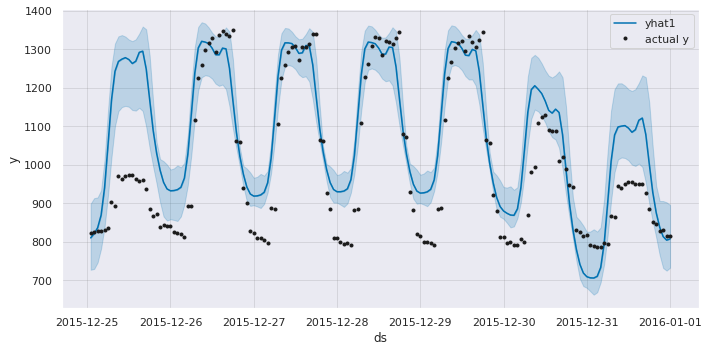

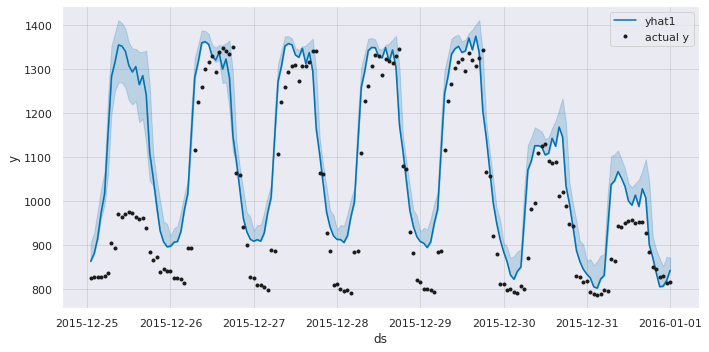

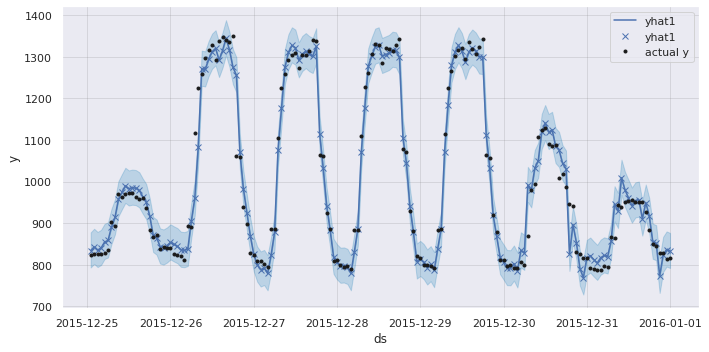

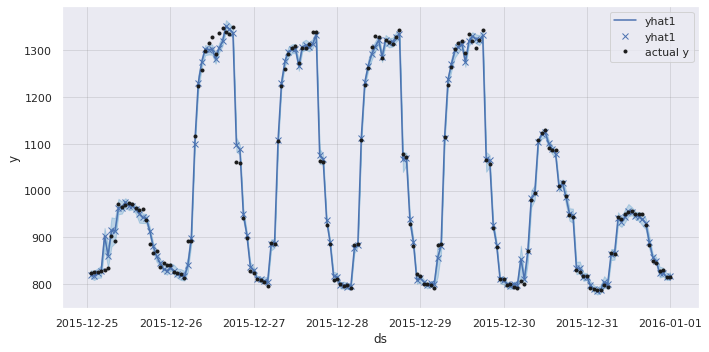

In [29]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

### Conformalize and plot

In [30]:
alpha = 0.1

**Naive**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


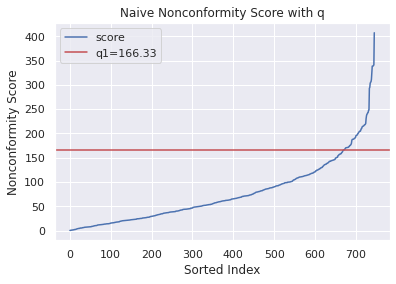

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


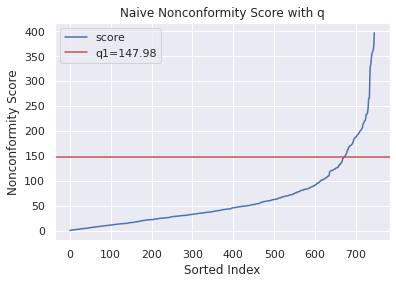

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


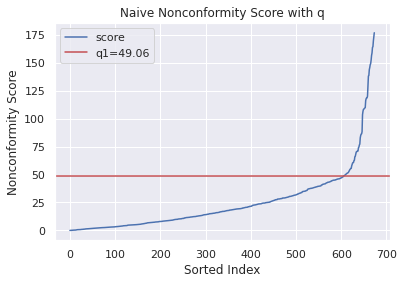

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


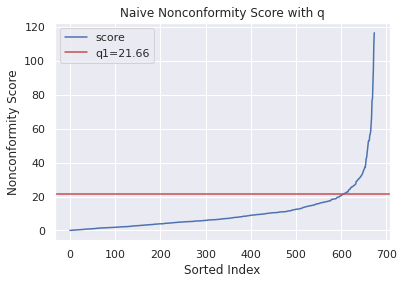

In [31]:
method='naive'
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)
m4.conformalize(cal_df, alpha=alpha, method=method)

In [32]:
naive_qhat1, naive_qhat2, naive_qhat3, naive_qhat4 = m1.q_hats[0], m2.q_hats[0], m3.q_hats[0], m4.q_hats[0]
naive_qhat1, naive_qhat2, naive_qhat3, naive_qhat4

(166.3265264531251, 147.98223420312502, 49.055130528125005, 21.65865092343745)

Get forecasts and *naive* conformal prediction interval of OOS test_df

In [33]:
naive_forecast1 = m1.predict(test_df)[n_lags:]
naive_forecast2 = m2.predict(test_df)[n_lags:]
naive_forecast3 = m3.predict(test_df)[n_lags:]
naive_forecast4 = m4.predict(test_df)[n_lags:]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [34]:
# method='naive'
# naive_forecast1 = m1.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast2 = m2.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast3 = m3.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast4 = m4.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)

In [35]:
naive_forecast1.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 - qhat1,yhat1 + qhat1
72,2015-12-12 06:00:00,879.551547,237.674772,1117.226318,1007.979248,1185.521484,1063.817139,61.650097,-8.240889,950.899792,1283.552845
73,2015-12-12 07:00:00,1102.066076,122.222742,1224.288818,1101.569092,1292.337891,1063.856567,60.726612,99.705711,1057.962292,1390.615345
74,2015-12-12 08:00:00,1214.971839,74.834191,1289.806030,1176.931763,1345.252930,1063.895996,59.697750,166.212280,1123.479504,1456.132557
75,2015-12-12 09:00:00,1257.597327,49.499353,1307.096680,1210.787354,1357.378784,1063.935303,58.594906,184.566467,1140.770153,1473.423206
76,2015-12-12 10:00:00,1293.807143,11.261094,1305.068237,1216.065063,1354.136230,1063.974731,57.448212,183.645309,1138.741711,1471.394764


In [36]:
naive_forecast2.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 - qhat1,yhat1 + qhat1
72,2015-12-12 06:00:00,879.551547,256.784024,1136.335571,1094.703979,1194.212891,1071.216919,70.309578,-5.190846,988.353337,1284.317805
73,2015-12-12 07:00:00,1102.066076,164.000819,1266.066895,1241.757568,1309.531982,1071.261597,77.058235,117.747009,1118.084660,1414.049129
74,2015-12-12 08:00:00,1214.971839,86.034997,1301.006836,1298.626953,1340.679932,1071.306396,82.131912,147.568466,1153.024602,1448.989070
75,2015-12-12 09:00:00,1257.597327,86.418542,1344.015869,1323.738281,1372.608643,1071.351196,85.320251,187.344330,1196.033635,1491.998103
76,2015-12-12 10:00:00,1293.807143,52.757066,1346.564209,1329.041138,1371.403564,1071.395996,86.519897,188.648331,1198.581975,1494.546443


In [37]:
naive_forecast3.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 - qhat1,yhat1 + qhat1
72,2015-12-12 06:00:00,879.551547,-4.145907,875.40564,834.49884,918.954468,128.263489,747.142151,826.350509,924.46077
73,2015-12-12 07:00:00,1102.066076,-29.101721,1072.964355,1032.056885,1116.513428,325.822174,747.142151,1023.909225,1122.019486
74,2015-12-12 08:00:00,1214.971839,-39.533118,1175.438721,1134.531006,1218.987793,428.296631,747.142151,1126.38359,1224.493851
75,2015-12-12 09:00:00,1257.597327,20.0953,1277.692627,1236.784302,1321.241333,530.550537,747.142151,1228.637496,1326.747757
76,2015-12-12 10:00:00,1293.807143,17.867173,1311.674316,1270.765747,1355.221924,564.532104,747.142151,1262.619186,1360.729447


In [38]:
naive_forecast4.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 - qhat1,yhat1 + qhat1
72,2015-12-12 06:00:00,879.551547,4.392789,883.944336,876.346191,888.811707,-63.687786,947.632141,862.285685,905.602987
73,2015-12-12 07:00:00,1102.066076,9.114222,1111.180298,1092.691528,1122.76001,163.548203,947.632141,1089.521647,1132.838949
74,2015-12-12 08:00:00,1214.971839,13.324914,1228.296753,1217.268921,1241.771606,280.664581,947.632141,1206.638102,1249.955404
75,2015-12-12 09:00:00,1257.597327,8.221765,1265.819092,1254.519043,1274.89917,318.187012,947.632141,1244.160441,1287.477743
76,2015-12-12 10:00:00,1293.807143,3.247667,1297.05481,1285.453125,1308.62915,349.422699,947.632141,1275.396159,1318.71346


Plot QR forecasts and *naive* conformal prediction intervals with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


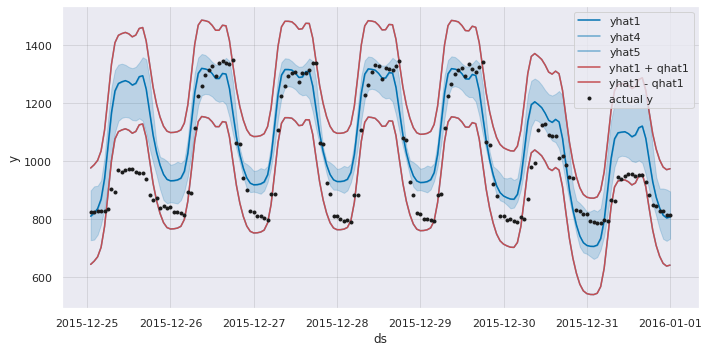

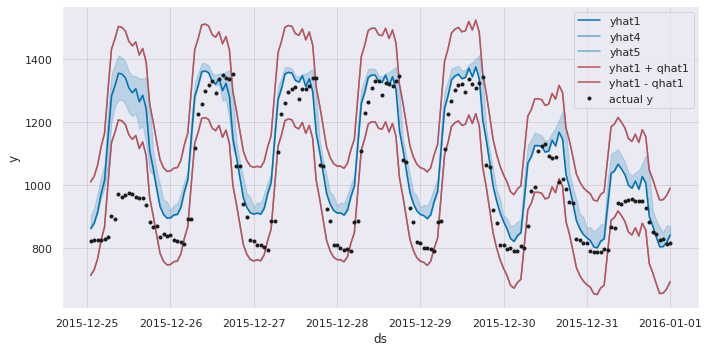

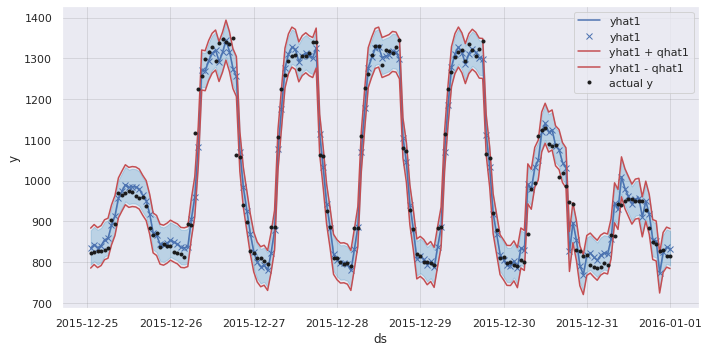

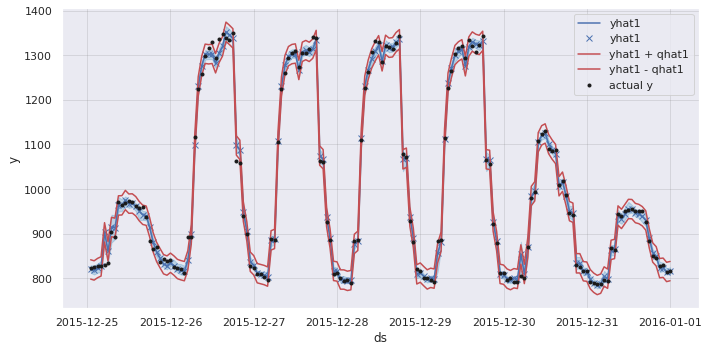

In [39]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(naive_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(naive_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(naive_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(naive_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

**CQR**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


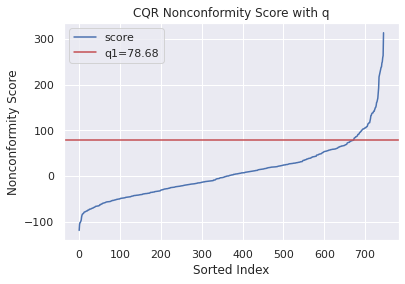

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


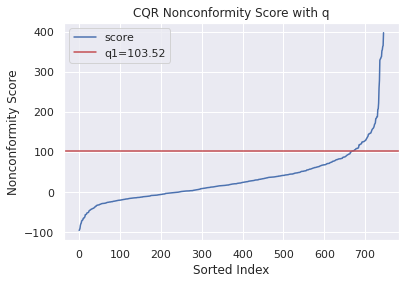

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


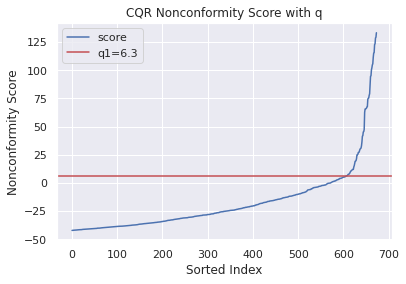

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


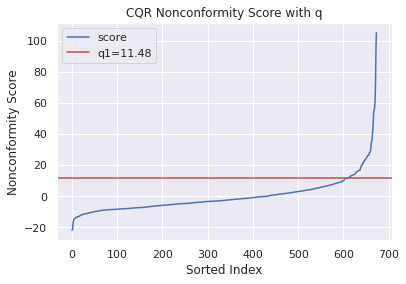

In [40]:
method='cqr'
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)
m4.conformalize(cal_df, alpha=alpha, method=method)

In [41]:
cqr_qhat1, cqr_qhat2, cqr_qhat3, cqr_qhat4 = m1.q_hats[0], m2.q_hats[0], m3.q_hats[0], m4.q_hats[0]
cqr_qhat1, cqr_qhat2, cqr_qhat3, cqr_qhat4

(78.68084134843753, 103.51727130937502, 6.295553921874898, 11.481231328906233)

Get forecasts and *CQR* conformal prediction interval of OOS test_df

In [42]:
cqr_forecast1 = m1.predict(test_df)[n_lags:]
cqr_forecast2 = m2.predict(test_df)[n_lags:]
cqr_forecast3 = m3.predict(test_df)[n_lags:]
cqr_forecast4 = m4.predict(test_df)[n_lags:]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [43]:
# method='cqr'
# cqr_adv_forecast1 = m1.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast2 = m2.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast3 = m3.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast4 = m4.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)

In [44]:
cqr_forecast1.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,237.674772,1117.226318,1007.979248,1185.521484,1063.817139,61.650097,-8.240889,1106.840643,1264.202326,929.298407,1086.660089
73,2015-12-12 07:00:00,1102.066076,122.222742,1224.288818,1101.569092,1292.337891,1063.856567,60.726612,99.705711,1213.657049,1371.018732,1022.888250,1180.249933
74,2015-12-12 08:00:00,1214.971839,74.834191,1289.806030,1176.931763,1345.252930,1063.895996,59.697750,166.212280,1266.572088,1423.933771,1098.250921,1255.612604
75,2015-12-12 09:00:00,1257.597327,49.499353,1307.096680,1210.787354,1357.378784,1063.935303,58.594906,184.566467,1278.697943,1436.059626,1132.106512,1289.468195
76,2015-12-12 10:00:00,1293.807143,11.261094,1305.068237,1216.065063,1354.136230,1063.974731,57.448212,183.645309,1275.455389,1432.817072,1137.384222,1294.745905


In [45]:
cqr_forecast2.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,256.784024,1136.335571,1094.703979,1194.212891,1071.216919,70.309578,-5.190846,1090.695619,1297.730162,991.186708,1198.221251
73,2015-12-12 07:00:00,1102.066076,164.000819,1266.066895,1241.757568,1309.531982,1071.261597,77.058235,117.747009,1206.014711,1413.049254,1138.240297,1345.274840
74,2015-12-12 08:00:00,1214.971839,86.034997,1301.006836,1298.626953,1340.679932,1071.306396,82.131912,147.568466,1237.162660,1444.197203,1195.109682,1402.144224
75,2015-12-12 09:00:00,1257.597327,86.418542,1344.015869,1323.738281,1372.608643,1071.351196,85.320251,187.344330,1269.091371,1476.125914,1220.221010,1427.255553
76,2015-12-12 10:00:00,1293.807143,52.757066,1346.564209,1329.041138,1371.403564,1071.395996,86.519897,188.648331,1267.886293,1474.920836,1225.523866,1432.558409


In [46]:
cqr_forecast3.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,-4.145907,875.40564,834.49884,918.954468,128.263489,747.142151,912.658914,925.250022,828.203286,840.794394
73,2015-12-12 07:00:00,1102.066076,-29.101721,1072.964355,1032.056885,1116.513428,325.822174,747.142151,1110.217874,1122.808982,1025.761331,1038.352439
74,2015-12-12 08:00:00,1214.971839,-39.533118,1175.438721,1134.531006,1218.987793,428.296631,747.142151,1212.692239,1225.283347,1128.235452,1140.82656
75,2015-12-12 09:00:00,1257.597327,20.0953,1277.692627,1236.784302,1321.241333,530.550537,747.142151,1314.945779,1327.536887,1230.488748,1243.079856
76,2015-12-12 10:00:00,1293.807143,17.867173,1311.674316,1270.765747,1355.221924,564.532104,747.142151,1348.92637,1361.517478,1264.470193,1277.061301


In [47]:
cqr_forecast4.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,4.392789,883.944336,876.346191,888.811707,-63.687786,947.632141,877.330475,900.292938,864.86496,887.827423
73,2015-12-12 07:00:00,1102.066076,9.114222,1111.180298,1092.691528,1122.76001,163.548203,947.632141,1111.278778,1134.241241,1081.210297,1104.17276
74,2015-12-12 08:00:00,1214.971839,13.324914,1228.296753,1217.268921,1241.771606,280.664581,947.632141,1230.290375,1253.252838,1205.78769,1228.750152
75,2015-12-12 09:00:00,1257.597327,8.221765,1265.819092,1254.519043,1274.89917,318.187012,947.632141,1263.417939,1286.380401,1243.037812,1266.000274
76,2015-12-12 10:00:00,1293.807143,3.247667,1297.05481,1285.453125,1308.62915,349.422699,947.632141,1297.147919,1320.110382,1273.971894,1296.934356


Plot QR forecasts and *CQR* conformal prediction interval with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


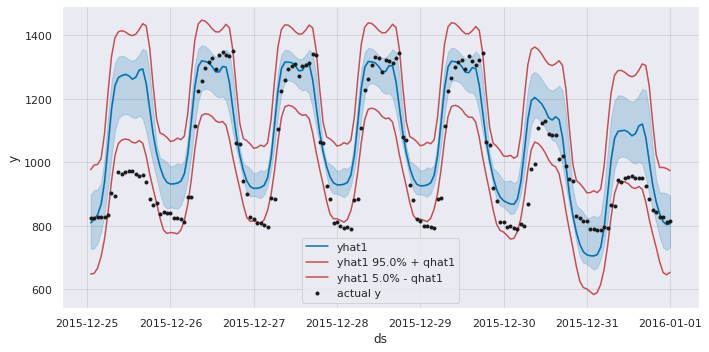

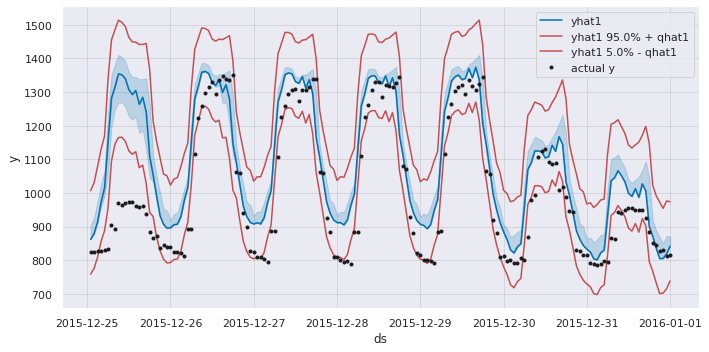

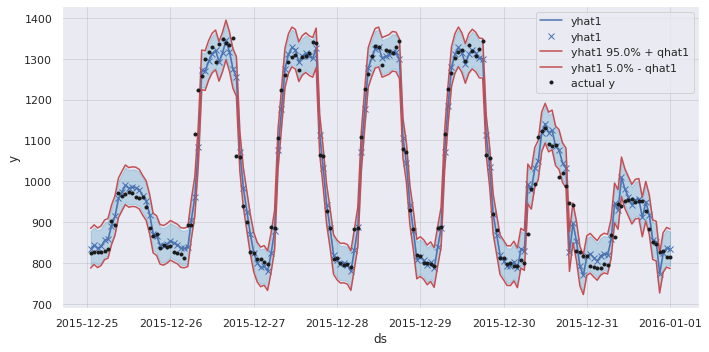

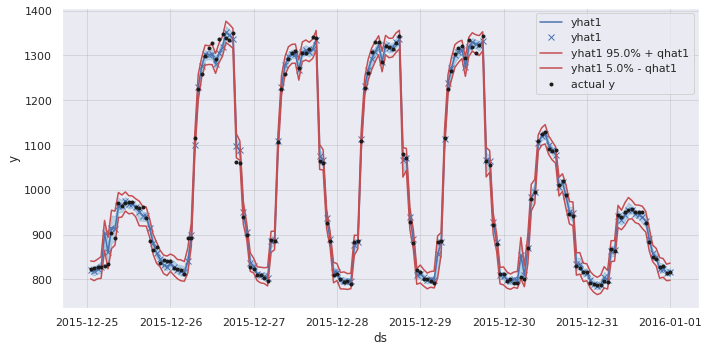

In [48]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

**CQR Advanced**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


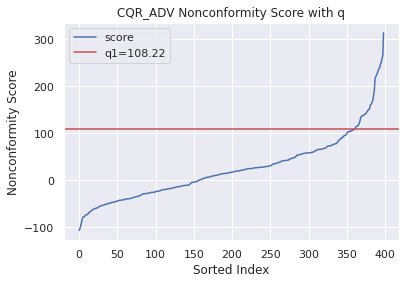

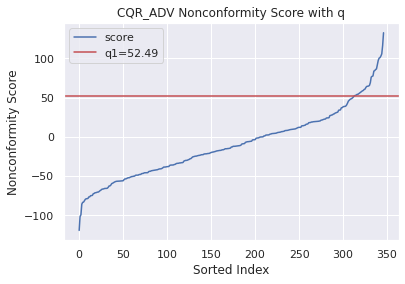

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


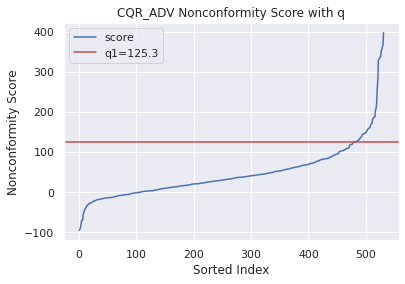

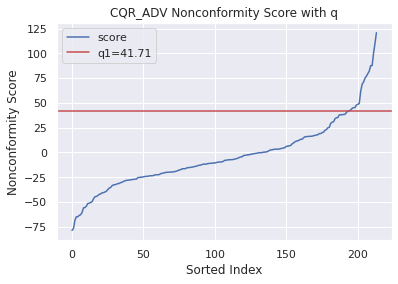

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


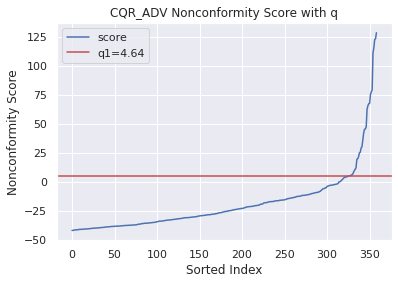

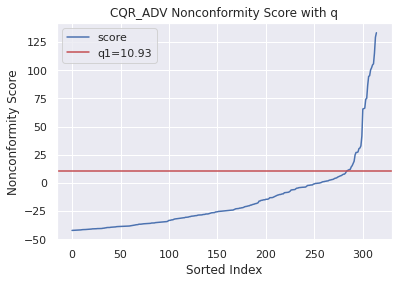

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


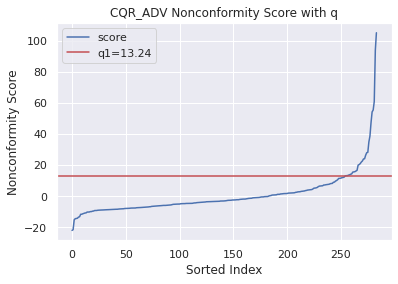

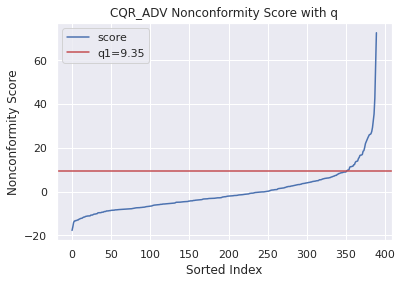

In [49]:
method='cqr_adv'
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)
m4.conformalize(cal_df, alpha=alpha, method=method)

In [50]:
cqr_lo_qhat1, cqr_lo_qhat2, cqr_lo_qhat3, cqr_lo_qhat4 = m1.q_hats[0], m2.q_hats[0], m3.q_hats[0], m4.q_hats[0]
cqr_hi_qhat1, cqr_hi_qhat2, cqr_hi_qhat3, cqr_hi_qhat4 = m1.q_hats[1], m2.q_hats[1], m3.q_hats[1], m4.q_hats[1]

cqr_lo_qhat1, cqr_hi_qhat1, cqr_lo_qhat2, cqr_hi_qhat2, cqr_lo_qhat3, cqr_hi_qhat3, cqr_lo_qhat4, cqr_hi_qhat4

(108.21679663437499,
 52.4949724999999,
 125.2962213414063,
 41.707756742187485,
 4.644985803906252,
 10.926609189843703,
 13.237638531250013,
 9.352127312499988)

In [51]:
# Compare again with CQR
cqr_qhat1, cqr_qhat2, cqr_qhat3, cqr_qhat4

(78.68084134843753, 103.51727130937502, 6.295553921874898, 11.481231328906233)

Get forecasts and *CQR Advanced* conformal prediction interval of OOS test_df

In [52]:
cqr_adv_forecast1 = m1.predict(test_df)[n_lags:]
cqr_adv_forecast2 = m2.predict(test_df)[n_lags:]
cqr_adv_forecast3 = m3.predict(test_df)[n_lags:]
cqr_adv_forecast4 = m4.predict(test_df)[n_lags:]

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [53]:
cqr_adv_forecast1.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,237.674772,1117.226318,1007.979248,1185.521484,1063.817139,61.650097,-8.240889,1133.026512,1238.016457,899.762451,1116.196045
73,2015-12-12 07:00:00,1102.066076,122.222742,1224.288818,1101.569092,1292.337891,1063.856567,60.726612,99.705711,1239.842918,1344.832863,993.352295,1209.785888
74,2015-12-12 08:00:00,1214.971839,74.834191,1289.806030,1176.931763,1345.252930,1063.895996,59.697750,166.212280,1292.757957,1397.747902,1068.714966,1285.148559
75,2015-12-12 09:00:00,1257.597327,49.499353,1307.096680,1210.787354,1357.378784,1063.935303,58.594906,184.566467,1304.883812,1409.873757,1102.570557,1319.004150
76,2015-12-12 10:00:00,1293.807143,11.261094,1305.068237,1216.065063,1354.136230,1063.974731,57.448212,183.645309,1301.641258,1406.631203,1107.848267,1324.281860


In [54]:
cqr_adv_forecast2.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,256.784024,1136.335571,1094.703979,1194.212891,1071.216919,70.309578,-5.190846,1152.505134,1235.920647,969.407758,1220.000201
73,2015-12-12 07:00:00,1102.066076,164.000819,1266.066895,1241.757568,1309.531982,1071.261597,77.058235,117.747009,1267.824226,1351.239739,1116.461347,1367.053790
74,2015-12-12 08:00:00,1214.971839,86.034997,1301.006836,1298.626953,1340.679932,1071.306396,82.131912,147.568466,1298.972175,1382.387688,1173.330732,1423.923174
75,2015-12-12 09:00:00,1257.597327,86.418542,1344.015869,1323.738281,1372.608643,1071.351196,85.320251,187.344330,1330.900886,1414.316399,1198.442060,1449.034503
76,2015-12-12 10:00:00,1293.807143,52.757066,1346.564209,1329.041138,1371.403564,1071.395996,86.519897,188.648331,1329.695808,1413.111321,1203.744916,1454.337359


In [55]:
cqr_adv_forecast3.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,-4.145907,875.40564,834.49884,918.954468,128.263489,747.142151,908.027859,929.881077,829.853855,839.143826
73,2015-12-12 07:00:00,1102.066076,-29.101721,1072.964355,1032.056885,1116.513428,325.822174,747.142151,1105.586819,1127.440037,1027.411899,1036.701871
74,2015-12-12 08:00:00,1214.971839,-39.533118,1175.438721,1134.531006,1218.987793,428.296631,747.142151,1208.061184,1229.914402,1129.88602,1139.175992
75,2015-12-12 09:00:00,1257.597327,20.0953,1277.692627,1236.784302,1321.241333,530.550537,747.142151,1310.314724,1332.167942,1232.139316,1241.429288
76,2015-12-12 10:00:00,1293.807143,17.867173,1311.674316,1270.765747,1355.221924,564.532104,747.142151,1344.295315,1366.148533,1266.120761,1275.410733


In [56]:
cqr_adv_forecast4.head()

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
72,2015-12-12 06:00:00,879.551547,4.392789,883.944336,876.346191,888.811707,-63.687786,947.632141,879.459579,898.163834,863.108553,889.58383
73,2015-12-12 07:00:00,1102.066076,9.114222,1111.180298,1092.691528,1122.76001,163.548203,947.632141,1113.407882,1132.112137,1079.45389,1105.929167
74,2015-12-12 08:00:00,1214.971839,13.324914,1228.296753,1217.268921,1241.771606,280.664581,947.632141,1232.419479,1251.123734,1204.031282,1230.506559
75,2015-12-12 09:00:00,1257.597327,8.221765,1265.819092,1254.519043,1274.89917,318.187012,947.632141,1265.547043,1284.251297,1241.281404,1267.756682
76,2015-12-12 10:00:00,1293.807143,3.247667,1297.05481,1285.453125,1308.62915,349.422699,947.632141,1299.277023,1317.981278,1272.215486,1298.690764


Plot QR forecasts and *CQR Advanced* conformal prediction interval with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


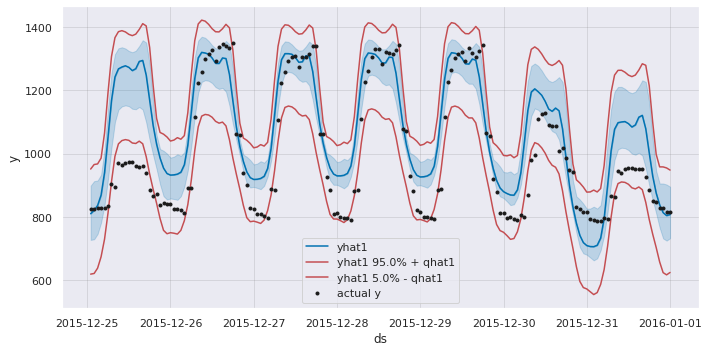

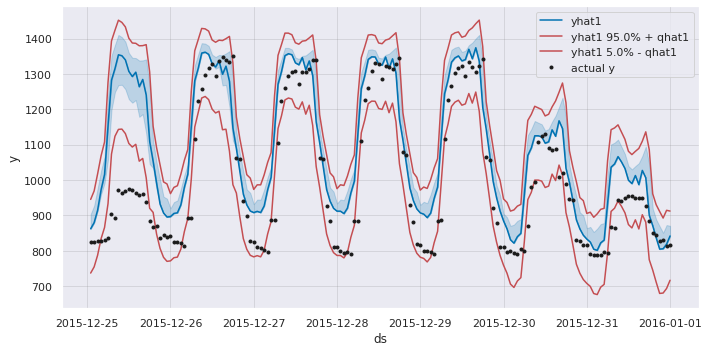

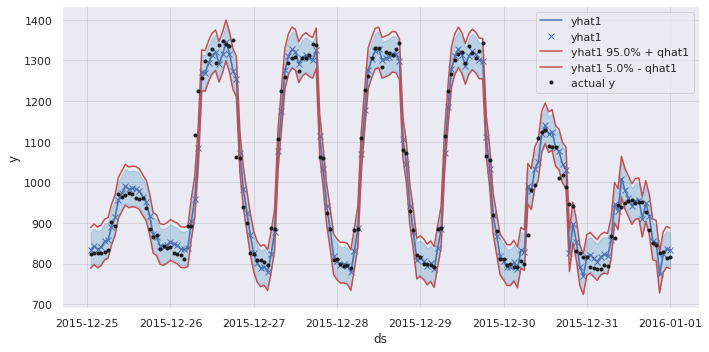

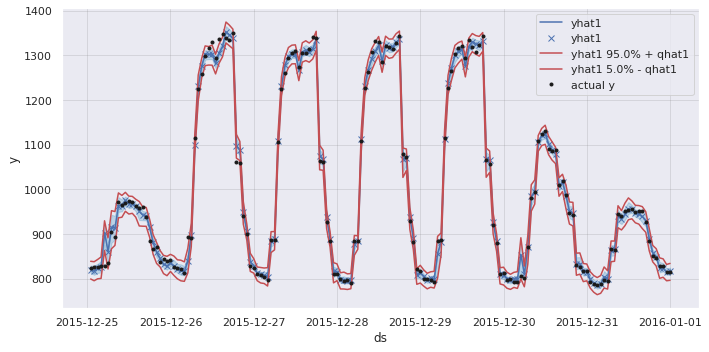

In [57]:
fig1 = m1.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_adv_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig2 = m2.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_adv_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig3 = m3.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_adv_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig4 = m4.highlight_nth_step_ahead_of_each_forecast(1) \
         .plot(cqr_adv_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

### Evaluate Performance

- **interval_width**: The average prediction interval, or q_hat multiplied by 2 because it is static or non-adaptive. Also the *efficiency* metric.
- **miscoverage_rate**: The actual miscoverage error rate on the OOS test set. Also the *validity* metric.

For the both metrics, the lower the number, the better the performance.



In [58]:
conformal_methods = ['naive', 'cqr', 'cqr_adv']
eval_df = pd.DataFrame(columns=pd.MultiIndex.from_product([conformal_methods, ['interval_width','miscoverage_rate']]))
eval_df = eval_df.reset_index().rename(columns={'index': 'model'})

Enter in the model names

In [59]:
eval_df['model'] = ['m1', 'm2', 'm3', 'm4']

Enter in the **interval_width** (*efficiency* metric)

In [60]:
# Naive interval width
naive_iw = [naive_qhat1*2, naive_qhat2*2, naive_qhat3*2, naive_qhat4*2]
eval_df['naive', 'interval_width'] = naive_iw

In [61]:
# Calculate CQR interval width function
def calc_cqr_iw(fcast_df, qr_lo, qr_hi, qhat):
    qr_lo_mean = fcast_df['yhat1'].mean() - fcast_df[f'yhat1 {qr_lo}%'].mean()
    qr_hi_mean = fcast_df[f'yhat1 {qr_hi}%'].mean() - fcast_df['yhat1'].mean()
    return qr_lo_mean + qr_hi_mean + qhat*2

In [62]:
# Quantile low/high values in string (%) format
quantile_lo_str = str(quantile_lo*100)
quantile_hi_str = str(quantile_hi*100)

In [63]:
# CQR interval width
cqr_iw1 = calc_cqr_iw(cqr_forecast1, quantile_lo_str, quantile_hi_str, cqr_qhat1)
cqr_iw2 = calc_cqr_iw(cqr_forecast2, quantile_lo_str, quantile_hi_str, cqr_qhat2)
cqr_iw3 = calc_cqr_iw(cqr_forecast3, quantile_lo_str, quantile_hi_str, cqr_qhat3)
cqr_iw4 = calc_cqr_iw(cqr_forecast4, quantile_lo_str, quantile_hi_str, cqr_qhat4)

cqr_iw = [cqr_iw1, cqr_iw2, cqr_iw3, cqr_iw4]
eval_df['cqr', 'interval_width'] = cqr_iw

In [64]:
# Calculate CQR Advanced interval width function
def calc_cqr_adv_iw(fcast_df, qr_lo, qr_hi, qhat_lo, qhat_hi):
    qr_lo_mean = fcast_df['yhat1'].mean() - fcast_df[f'yhat1 {qr_lo}%'].mean()
    qr_hi_mean = fcast_df[f'yhat1 {qr_hi}%'].mean() - fcast_df['yhat1'].mean()
    return qr_lo_mean + qr_hi_mean + qhat_lo + qhat_hi

In [65]:
# CQR Advanced interval width
cqr_adv_iw1 = calc_cqr_adv_iw(cqr_adv_forecast1, quantile_lo_str, quantile_hi_str, cqr_lo_qhat1, cqr_hi_qhat1)
cqr_adv_iw2 = calc_cqr_adv_iw(cqr_adv_forecast2, quantile_lo_str, quantile_hi_str, cqr_lo_qhat2, cqr_hi_qhat2)
cqr_adv_iw3 = calc_cqr_adv_iw(cqr_adv_forecast3, quantile_lo_str, quantile_hi_str, cqr_lo_qhat3, cqr_hi_qhat3)
cqr_adv_iw4 = calc_cqr_adv_iw(cqr_adv_forecast4, quantile_lo_str, quantile_hi_str, cqr_lo_qhat4, cqr_hi_qhat4)

cqr_adv_iw = [cqr_adv_iw1, cqr_adv_iw2, cqr_adv_iw3, cqr_adv_iw4]
eval_df['cqr_adv', 'interval_width'] = cqr_adv_iw

Enter in the **miscoverage rate** (*validity* metric)

In [66]:
# Calculate Naive miscoverage rate function
def calc_naive_mr(fcast_df):
    n_covered = fcast_df.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

In [67]:
# Naive miscoverage rate
naive_mr1 = calc_naive_mr(naive_forecast1)
naive_mr2 = calc_naive_mr(naive_forecast2)
naive_mr3 = calc_naive_mr(naive_forecast3)
naive_mr4 = calc_naive_mr(naive_forecast4)

naive_mr = [naive_mr1, naive_mr2, naive_mr3, naive_mr4]
eval_df['naive', 'miscoverage_rate'] = naive_mr

In [68]:
# Calculate CQR and CQR Advanced miscoverage rate function
def calc_cqr_mr(fcast_df, qr_lo, qr_hi):
    n_covered = fcast_df.apply(lambda row: bool(row[f'yhat1 {qr_lo}% - qhat1'] <= row['y'] <= row[f'yhat1 {qr_hi}% + qhat1']), axis=1)
    coverage_rate = n_covered.sum() / len(fcast_df)
    return 1 - coverage_rate

In [69]:
# CQR miscoverage rate
cqr_mr1 = calc_cqr_mr(cqr_forecast1, quantile_lo_str, quantile_hi_str)
cqr_mr2 = calc_cqr_mr(cqr_forecast2, quantile_lo_str, quantile_hi_str)
cqr_mr3 = calc_cqr_mr(cqr_forecast3, quantile_lo_str, quantile_hi_str)
cqr_mr4 = calc_cqr_mr(cqr_forecast4, quantile_lo_str, quantile_hi_str)

cqr_mr = [cqr_mr1, cqr_mr2, cqr_mr3, cqr_mr4]
eval_df['cqr', 'miscoverage_rate'] = cqr_mr

In [70]:
# CQR Advanced miscoverage rate
cqr_adv_mr1 = calc_cqr_mr(cqr_adv_forecast1, quantile_lo_str, quantile_hi_str)
cqr_adv_mr2 = calc_cqr_mr(cqr_adv_forecast2, quantile_lo_str, quantile_hi_str)
cqr_adv_mr3 = calc_cqr_mr(cqr_adv_forecast3, quantile_lo_str, quantile_hi_str)
cqr_adv_mr4 = calc_cqr_mr(cqr_adv_forecast4, quantile_lo_str, quantile_hi_str)

cqr_adv_mr = [cqr_adv_mr1, cqr_adv_mr2, cqr_adv_mr3, cqr_adv_mr4]
eval_df['cqr_adv', 'miscoverage_rate'] = cqr_adv_mr

Show evaluation dataframe

In [71]:
eval_df

model          naive                             cqr                   \
        interval_width miscoverage_rate interval_width miscoverage_rate   
0    m1     332.653053         0.117895     292.580898         0.189474   
1    m2     295.964468         0.138947     263.018787         0.193684   
2    m3      98.110261         0.090526      97.042411         0.092632   
3    m4      43.317302         0.077895      44.818693         0.071579   

         cqr_adv                   
  interval_width miscoverage_rate  
0     295.930985         0.122105  
1     222.988222         0.157895  
2     100.022898         0.071579  
3      44.445996         0.073684

**Summary**: 

CQR outputs narrower prediction *interval width* than Naive while maintaining slightly better *miscoverage rate* (for the advanced AR models m4 and m4). The complex m4 model performs the best for *interval_width* while the simple m1 performs the best for actual *miscoverage rate*, hovering around *alpha*. However, that is because it has also by far the highest *interval_width*. m3 and m4 models have actual *miscoverage rates* are roughly twice the amount as the intended *alpha* of 0.1, which is consistent with the conformal prediction literature.